In [1]:
import os
import re
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 500)

                         file   total   train    val   pred
0          Ukraine_troops.csv  172714  120899  34543  17272
1             Ukraine_war.csv  231624  162136  46325  23163
2           Russia_invade.csv  170835  119584  34167  17084
3            Ukraine_nato.csv  245232  171662  49046  24524
4          Russian_troops.csv  128405   89883  25681  12841
5        StandWithUkraine.csv  148145  103701  29629  14815
6          Ukraine_border.csv  166610  116627  33322  16661
7  Russian_border_Ukraine.csv   53040   37128  10608   5304


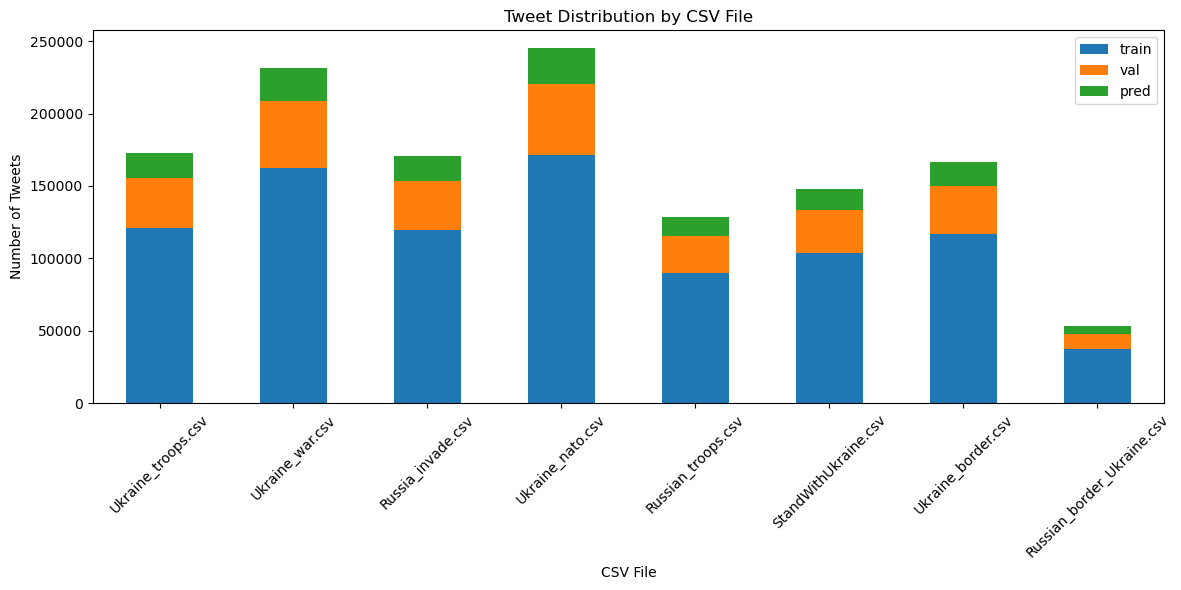

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set path to folder
data_path = 'archive/'
file_list = [f for f in os.listdir(data_path) if f.endswith('.csv')]

summary = []

# Process each file
for file in file_list:
    file_path = os.path.join(data_path, file)
    df = pd.read_csv(file_path)
    
    tweet_count = len(df)
    
    # Split into train (70%), validation (20%), prediction (10%)
    train, temp = train_test_split(df, test_size=0.3, random_state=42)
    val, pred = train_test_split(temp, test_size=1/3, random_state=42)
    
    summary.append({
        'file': file,
        'total': tweet_count,
        'train': len(train),
        'val': len(val),
        'pred': len(pred)
    })

# Convert summary to DataFrame
summary_df = pd.DataFrame(summary)

# Display summary
print(summary_df)

# Plot distribution
summary_df.set_index('file')[['train', 'val', 'pred']].plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Tweet Distribution by CSV File')
plt.xlabel('CSV File')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 1. Combining File

In [20]:

def combine_csv_files(input_folder, output_file='combined_data.csv'):
    all_files = glob.glob(os.path.join(input_folder, "*.csv"))
    df_list = [pd.read_csv(f) for f in all_files]
    combined_df = pd.concat(df_list, ignore_index=True)
    combined_df.to_csv(output_file, index=False)
    return combined_df

# Usage example
combined_df = combine_csv_files('./archive')
print(f"Combined dataset shape: {combined_df.shape}")


KeyboardInterrupt: 

# 2. Removing Clearing words, Hastags, URLS

In [ ]:

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # remove URLs
    text = re.sub(r'@\w+', '', text)  # remove mentions
    text = re.sub(r'#', ' ', text)     # remove hashtags symbol
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuations & numbers
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

combined_df['clean_text'] = combined_df['content'].apply(clean_text)
print(combined_df[['clean_text']].head(10))


In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

combined_df['clean_text'] = combined_df['clean_text'].apply(remove_stopwords)


In [ ]:
combined_df[['clean_text']].head(10)

# 3. Tokenize Words

In [12]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')



[nltk_data] Downloading package punkt to /Users/sourav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/sourav/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [13]:
combined_df['tokens'] = combined_df['clean_text'].apply(word_tokenize)
print(combined_df['tokens'].head())

0                                                                                                                  [hugs, hope, spread, russian, ukraine, troops, ukraine, nowar, stopthewar, weareallfriends, wakeuptroops, hugstoall]
1                                                                          [ukraine, officials, bellingcat, pentagon, statements, partly, every, russian, air, force, loss, photocaptured, cant, made, tanks, troops, obvious, reasons]
2    [young, ukrainian, volunteer, killed, russian, invaders, delivering, food, dog, shelter, ukraine, remember, defenders, name, honor, forever, putin, burns, dead, troops, mobile, crematoriums, standwithukraine, putinwarcriminal]
3                                                                                                                                          [want, talk, coercion, russian, troops, threatened, shot, refuse, invade, ukraine, coercion]
4                                                                       

In [21]:
df = combined_df[combined_df['clean_text'].notnull()]
df = df[df['clean_text'].str.strip() != '']
df = df.reset_index(drop=True)

df.to_csv('cleared_data.csv')

# Labelling the Data

In [16]:
from transformers import pipeline
import pandas as pd
from tqdm import tqdm
import torch
from sklearn.model_selection import train_test_split

# Define candidate labels
candidate_labels = [
    "formal", "informal", "optimistic", "humorous", "assertive", "aggressive",
    "pessimistic", "serious", "persuasive", "inspirational", "curious"
]

# Detect device
device = 0 if torch.backends.mps.is_available() else -1
print(f"💻 Using {'Apple MPS' if device == 0 else 'CPU'}")

# Load model
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device)

# STEP 1: Drop null or empty rows
df = combined_df[combined_df['clean_text'].notnull()]
df = df[df['clean_text'].str.strip() != '']
df = df.reset_index(drop=True)

# STEP 2: Split into train (70%), val (20%), test (10%) → only label train + val
train_val_df, test_df = train_test_split(df, test_size=0.10, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2222, random_state=42)  # 0.2222 × 90% ≈ 20%

print(f"✅ Train: {len(train_df)} | Validation: {len(val_df)} | Prediction (unlabeled): {len(test_df)}")

# STEP 3: Define labeling function
def label_chunk(df_chunk):
    results = []
    for text in tqdm(df_chunk['clean_text'], desc="Labelling"):
        try:
            result = classifier(text, candidate_labels)
            results.append(result['labels'][0])
        except Exception:
            results.append("unlabeled")
    df_chunk['auto_label'] = results
    return df_chunk

# STEP 4: Label training and validation data
train_df = label_chunk(train_df)
val_df = label_chunk(val_df)

# STEP 5: Combine labeled and unlabeled
labeled_df = pd.concat([train_df, val_df], ignore_index=True)
unlabeled_df = test_df.copy()
unlabeled_df['auto_label'] = "unlabeled"

# STEP 6: Final combined DataFrame
final_df = pd.concat([labeled_df, unlabeled_df], ignore_index=True)

# ✅ Done
print("\n🔎 Final labeled data preview:")
print(final_df[['clean_text', 'auto_label']].sample(5))


💻 Using Apple MPS


Device set to use mps:0


✅ Train: 920789 | Validation: 263050 | Prediction (unlabeled): 131538


Labelling:   1%|▏                     | 5928/920789 [52:39<135:26:59,  1.88it/s]


KeyboardInterrupt: 